<a href="https://colab.research.google.com/github/irina-marko/Minimal-metric-dimension/blob/main/vns_grid_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
import random
from itertools import combinations
import time
import matplotlib.pyplot as plt


In [2]:
def precompute_shortest_paths(G):
    return dict(nx.all_pairs_bellman_ford_path_length(G))

In [3]:
def is_resolving_set(G, nodes, shortest_paths):
    for u, v in combinations(G.nodes, 2):
        distances_u = [shortest_paths[u][node] for node in nodes]
        distances_v = [shortest_paths[v][node] for node in nodes]

        if not any(dist_u != dist_v for dist_u, dist_v in zip(distances_u, distances_v)):
            return False
    return True

In [4]:
def fitness(G, nodes, shortest_paths):
    if is_resolving_set(G, nodes, shortest_paths):
        return len(nodes)
    else:
        return float('inf')

In [5]:
def generate_connected_erdos_renyi(n, p):
    G = nx.erdos_renyi_graph(n, p)
    if nx.is_connected(G):
        return G
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        return G.subgraph(largest_cc).copy()


In [6]:
def generate_connected_watts_strogatz(n, k, p):
    G = nx.watts_strogatz_graph(n, k, p)
    if nx.is_connected(G):
        return G
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        return G.subgraph(largest_cc).copy()


In [7]:
def generate_connected_barabasi_albert(n, m):
    G = nx.barabasi_albert_graph(n, m)
    if nx.is_connected(G):
        return G
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        return G.subgraph(largest_cc).copy()


In [8]:
def generate_connected_powerlaw(n, m, p):
    G = nx.powerlaw_cluster_graph(n, m, p)
    if nx.is_connected(G):
        return G
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        return G.subgraph(largest_cc).copy()


In [9]:
def generate_connected_random_regular(n, d):
    G = nx.random_regular_graph(d, n)
    if nx.is_connected(G):
        return G
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        return G.subgraph(largest_cc).copy()




In [10]:
def draw_graph(G, title):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
    plt.title(title)
    plt.show()

In [11]:
def local_search_add(solution, G, nodes_list, shortest_paths):
    best_local_solution = solution[:]
    best_local_fitness = fitness(G, solution, shortest_paths)
    candidates = list(set(nodes_list) - set(solution))
    for node in candidates:
        new_solution = solution + [node]
        new_fitness = fitness(G, new_solution, shortest_paths)
        if new_fitness < best_local_fitness:
            best_local_solution = new_solution
            best_local_fitness = new_fitness
    return best_local_solution

In [12]:
def local_search_remove(solution, G, shortest_paths):
    best_local_solution = solution[:]
    best_local_fitness = fitness(G, solution, shortest_paths)
    for i in range(len(solution)):
        new_solution = solution[:i] + solution[i+1:]
        new_fitness = fitness(G, new_solution, shortest_paths)
        if new_fitness < best_local_fitness:
            best_local_solution = new_solution
            best_local_fitness = new_fitness
    return best_local_solution

In [13]:
def local_search_swap(solution, G, nodes_list, shortest_paths):
    best_local_solution = solution[:]
    best_local_fitness = fitness(G, solution, shortest_paths)
    for i in range(len(solution)):
        for node in nodes_list:
            if node not in solution:
                new_solution = solution[:]
                new_solution[i] = node
                new_fitness = fitness(G, new_solution, shortest_paths)
                if new_fitness < best_local_fitness:
                    best_local_solution = new_solution
                    best_local_fitness = new_fitness
    return best_local_solution

In [14]:
def local_search(solution, nodes_list, G, shortest_paths):
    best_solution = solution[:]
    improved = True
    iteration_count = 0

    while improved:
        improved = False


        for operation in ['add', 'remove', 'swap']:
            iteration_count += 1
            print(f"Trying operation: {operation} on {best_solution}")
            if operation == 'add':
                new_solution = local_search_add(best_solution, G, nodes_list, shortest_paths)
            elif operation == 'remove':
                new_solution = local_search_remove(best_solution, G, shortest_paths)
            elif operation == 'swap':
                new_solution = local_search_swap(best_solution, G, nodes_list, shortest_paths)

            if fitness(G, new_solution, shortest_paths) < fitness(G, best_solution, shortest_paths):
                best_solution = new_solution
                improved = True


    return best_solution


In [15]:
def generate_initial_solution(nodes_list):
    return random.sample(nodes_list, random.randint(1, len(nodes_list)))

In [16]:
def add_node(solution, nodes_list):
    candidates = list(set(nodes_list) - set(solution))
    if candidates:
        new_node = random.choice(candidates)
        return solution + [new_node]
    return solution

In [17]:
def remove_node(solution):
    if solution:
        solution.remove(random.choice(solution))
    return solution



In [18]:
def swap_node(solution, nodes_list):
    if solution:
        candidates = list(set(nodes_list) - set(solution))
        if candidates:
            solution[random.randint(0, len(solution) - 1)] = random.choice(candidates)
    return solution

In [19]:

def shaking(solution, nodes_list):
    operation = random.choice(['add', 'remove', 'swap'])
    print(f"Shaking operation: {operation} on solution: {solution}")

    if operation == 'add':
        solution = add_node(solution, nodes_list)
    elif operation == 'remove' and solution:
        solution = remove_node(solution)
    elif operation == 'swap' and solution:
        solution = swap_node(solution, nodes_list)


    return solution


In [20]:
def VNS(G, max_iterations, time_limit):
    start_time = time.time()
    nodes_list = list(G.nodes)
    shortest_paths = precompute_shortest_paths(G)
    current_solution = generate_initial_solution(nodes_list)
    best_solution = current_solution

    print(f"Initial solution: {current_solution}, Metric dimension: {fitness(G, best_solution, shortest_paths)}")

    for iteration in range(max_iterations):

        if (time.time() - start_time) > time_limit:
            print(f"Iteration time limit of {time_limit} seconds reached, moving to the next iteration.")
            break

        new_solution = shaking(current_solution, nodes_list)


        improved_solution = local_search(new_solution, nodes_list, G, shortest_paths)

        if fitness(G, improved_solution, shortest_paths) < fitness(G, best_solution, shortest_paths):
            best_solution = improved_solution
            current_solution = improved_solution
        else:
            current_solution = improved_solution

    print(f"Final best solution after {iteration} iterations: {best_solution} with metric dimension: {fitness(G, best_solution, shortest_paths)}")
    return best_solution


In [21]:
def optimize_parameters(G, max_iterations_list, time_limits):
    best_overall_solution = None
    best_fitness = float('inf')
    best_params = None

    for max_iterations in max_iterations_list:
        for time_limit in time_limits:

            start_time = time.time()
            solution = VNS(G, max_iterations=max_iterations, time_limit=time_limit)
            current_fitness = fitness(G, solution, precompute_shortest_paths(G))

            elapsed_time = time.time() - start_time

            print(f"Elapsed time for this parameter set: {elapsed_time:.5f} seconds")

            if current_fitness < best_fitness:
                best_fitness = current_fitness
                best_overall_solution = solution
                best_params = (max_iterations, time_limit)

    print(f"Best overall solution: {best_overall_solution} with fitness: {best_fitness}, parameters: {best_params}")
    return best_overall_solution, best_params



Erdős-Rényi Random Graph


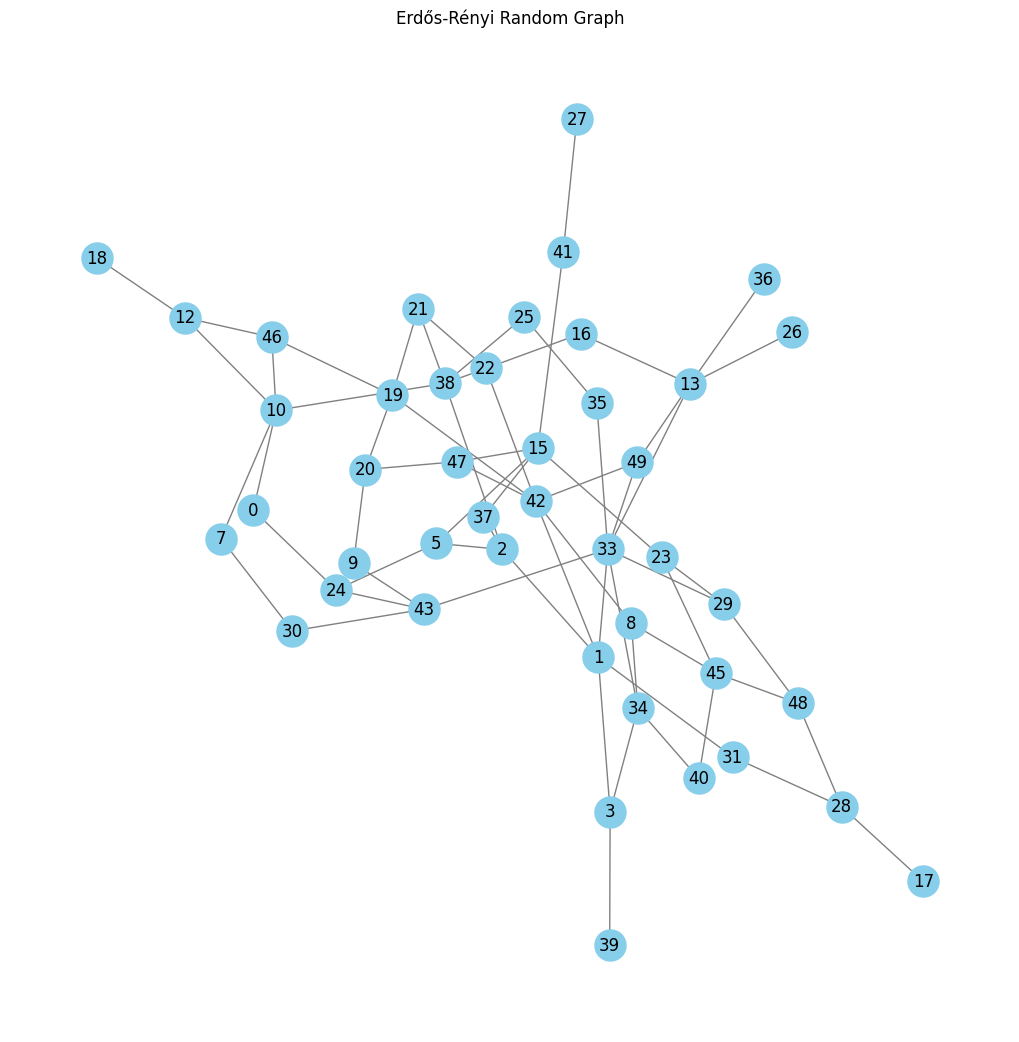

Initial solution: [2, 39, 35, 24, 46, 28, 26, 12, 15, 43, 7, 10, 40, 0, 13, 20, 5, 27], Metric dimension: 18
Shaking operation: swap on solution: [2, 39, 35, 24, 46, 28, 26, 12, 15, 43, 7, 10, 40, 0, 13, 20, 5, 27]
Trying operation: add on [2, 39, 35, 24, 46, 28, 26, 41, 15, 43, 7, 10, 40, 0, 13, 20, 5, 27]
Trying operation: remove on [2, 39, 35, 24, 46, 28, 26, 41, 15, 43, 7, 10, 40, 0, 13, 20, 5, 27]
Trying operation: swap on [39, 35, 24, 46, 28, 26, 41, 15, 43, 7, 10, 40, 0, 13, 20, 5, 27]
Trying operation: add on [39, 35, 24, 46, 28, 26, 41, 15, 43, 7, 10, 40, 0, 13, 20, 5, 27]
Trying operation: remove on [39, 35, 24, 46, 28, 26, 41, 15, 43, 7, 10, 40, 0, 13, 20, 5, 27]
Trying operation: swap on [35, 24, 46, 28, 26, 41, 15, 43, 7, 10, 40, 0, 13, 20, 5, 27]
Trying operation: add on [35, 24, 46, 28, 26, 41, 15, 43, 7, 10, 40, 0, 13, 20, 5, 27]
Trying operation: remove on [35, 24, 46, 28, 26, 41, 15, 43, 7, 10, 40, 0, 13, 20, 5, 27]
Trying operation: swap on [24, 46, 28, 26, 41, 15, 4

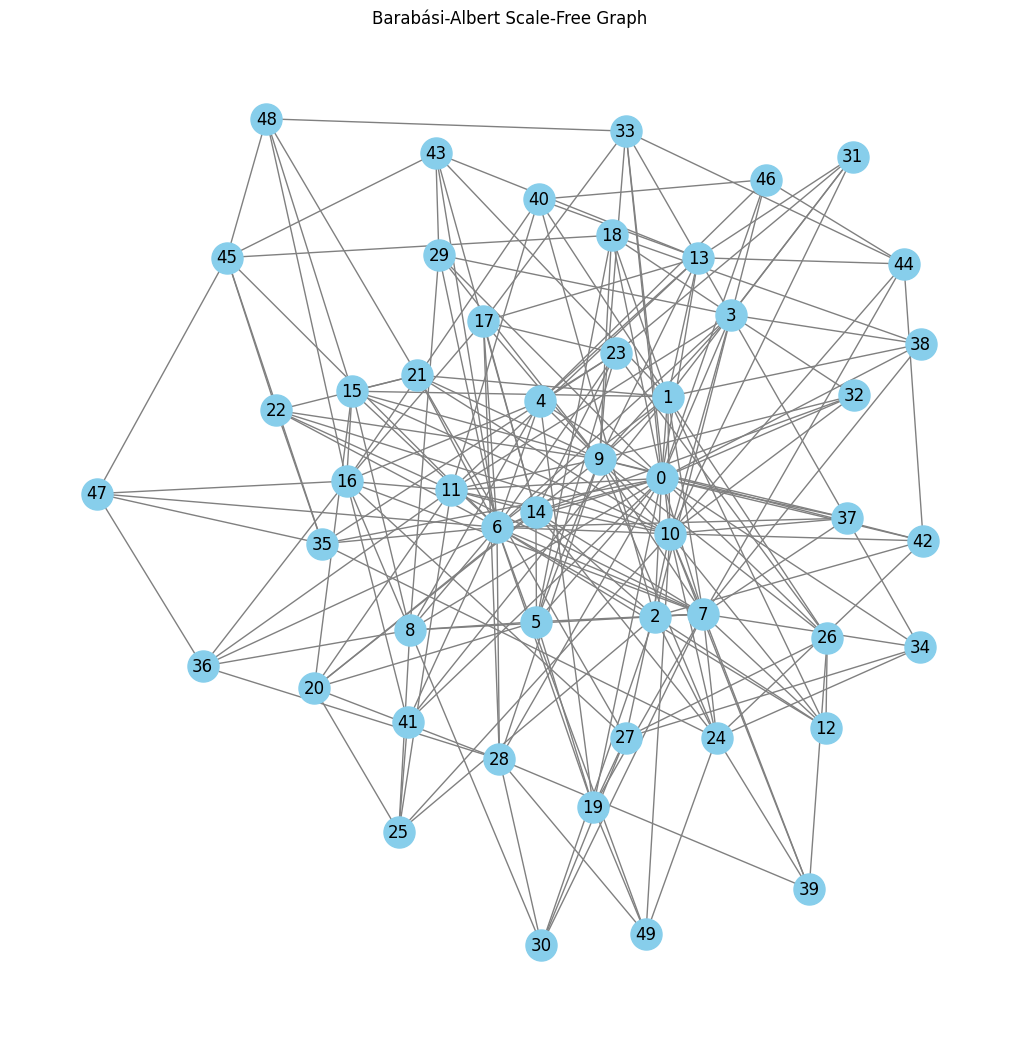

Initial solution: [30, 45, 33, 23], Metric dimension: inf
Shaking operation: remove on solution: [30, 45, 33, 23]
Trying operation: add on [45, 33, 23]
Trying operation: remove on [45, 33, 23]
Trying operation: swap on [45, 33, 23]
Shaking operation: add on solution: [45, 33, 23]
Trying operation: add on [45, 33, 23, 9]
Trying operation: remove on [45, 33, 23, 9]
Trying operation: swap on [45, 33, 23, 9]
Shaking operation: add on solution: [45, 33, 23, 9]
Trying operation: add on [45, 33, 23, 9, 18]
Trying operation: remove on [45, 33, 23, 9, 18]
Trying operation: swap on [45, 33, 23, 9, 18]
Shaking operation: swap on solution: [45, 33, 23, 9, 18]
Trying operation: add on [45, 40, 23, 9, 18]
Trying operation: remove on [45, 40, 23, 9, 18]
Trying operation: swap on [45, 40, 23, 9, 18]
Iteration time limit of 0.3 seconds reached, moving to the next iteration.
Final best solution after 4 iterations: [45, 33, 23] with metric dimension: inf
Elapsed time for this parameter set: 0.38830 secon

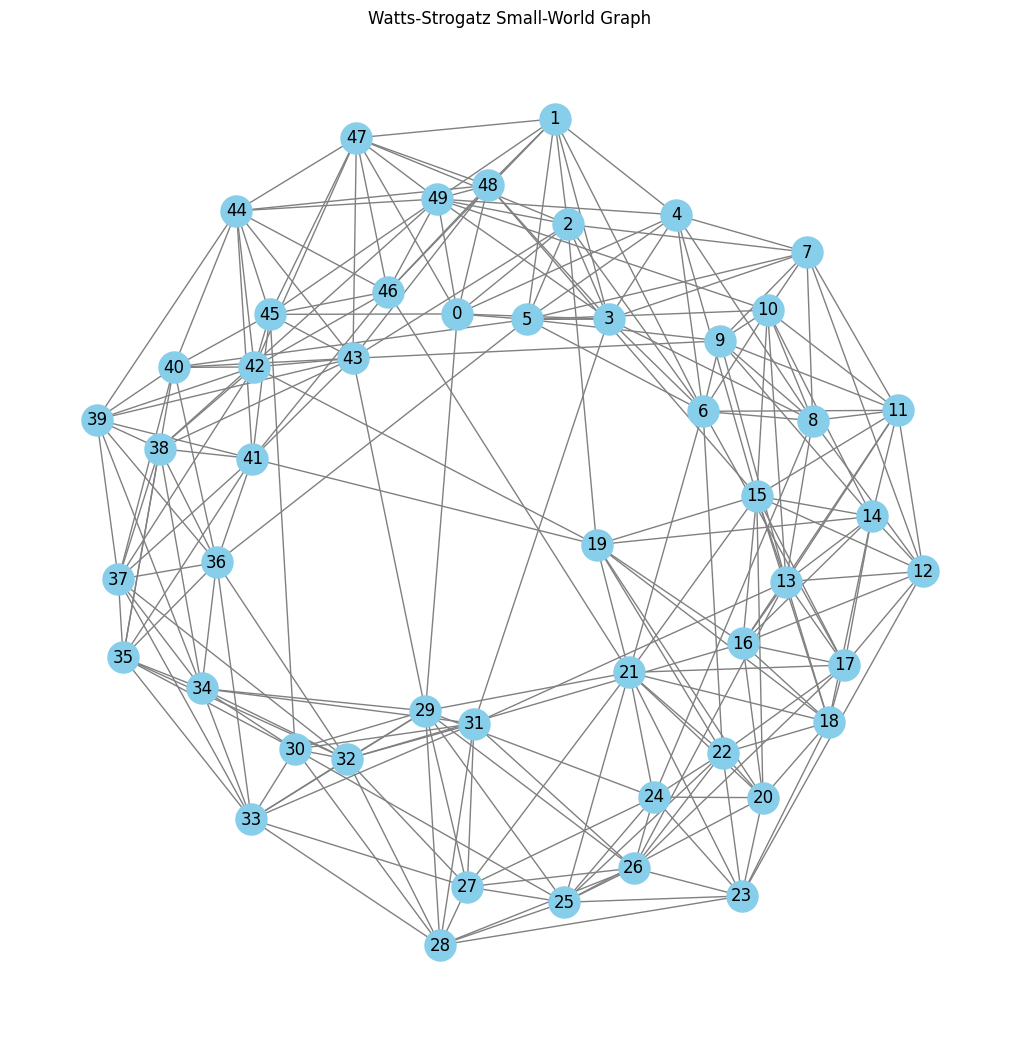

Initial solution: [43, 39, 44, 17, 13, 23, 47, 37, 12, 46, 34, 20, 41, 1], Metric dimension: inf
Shaking operation: remove on solution: [43, 39, 44, 17, 13, 23, 47, 37, 12, 46, 34, 20, 41, 1]
Trying operation: add on [43, 39, 44, 17, 13, 23, 47, 37, 46, 34, 20, 41, 1]
Trying operation: remove on [43, 39, 44, 17, 13, 23, 47, 37, 46, 34, 20, 41, 1, 3]
Trying operation: swap on [39, 44, 17, 13, 23, 47, 37, 46, 34, 20, 41, 1, 3]
Trying operation: add on [39, 44, 17, 13, 23, 47, 37, 46, 34, 20, 41, 1, 3]
Trying operation: remove on [39, 44, 17, 13, 23, 47, 37, 46, 34, 20, 41, 1, 3]
Trying operation: swap on [44, 17, 13, 23, 47, 37, 46, 34, 20, 41, 1, 3]
Trying operation: add on [44, 17, 13, 23, 47, 37, 46, 34, 20, 41, 1, 3]
Trying operation: remove on [44, 17, 13, 23, 47, 37, 46, 34, 20, 41, 1, 3]
Trying operation: swap on [44, 17, 23, 47, 37, 46, 34, 20, 41, 1, 3]
Trying operation: add on [44, 17, 23, 47, 37, 46, 34, 20, 41, 1, 3]
Trying operation: remove on [44, 17, 23, 47, 37, 46, 34, 20

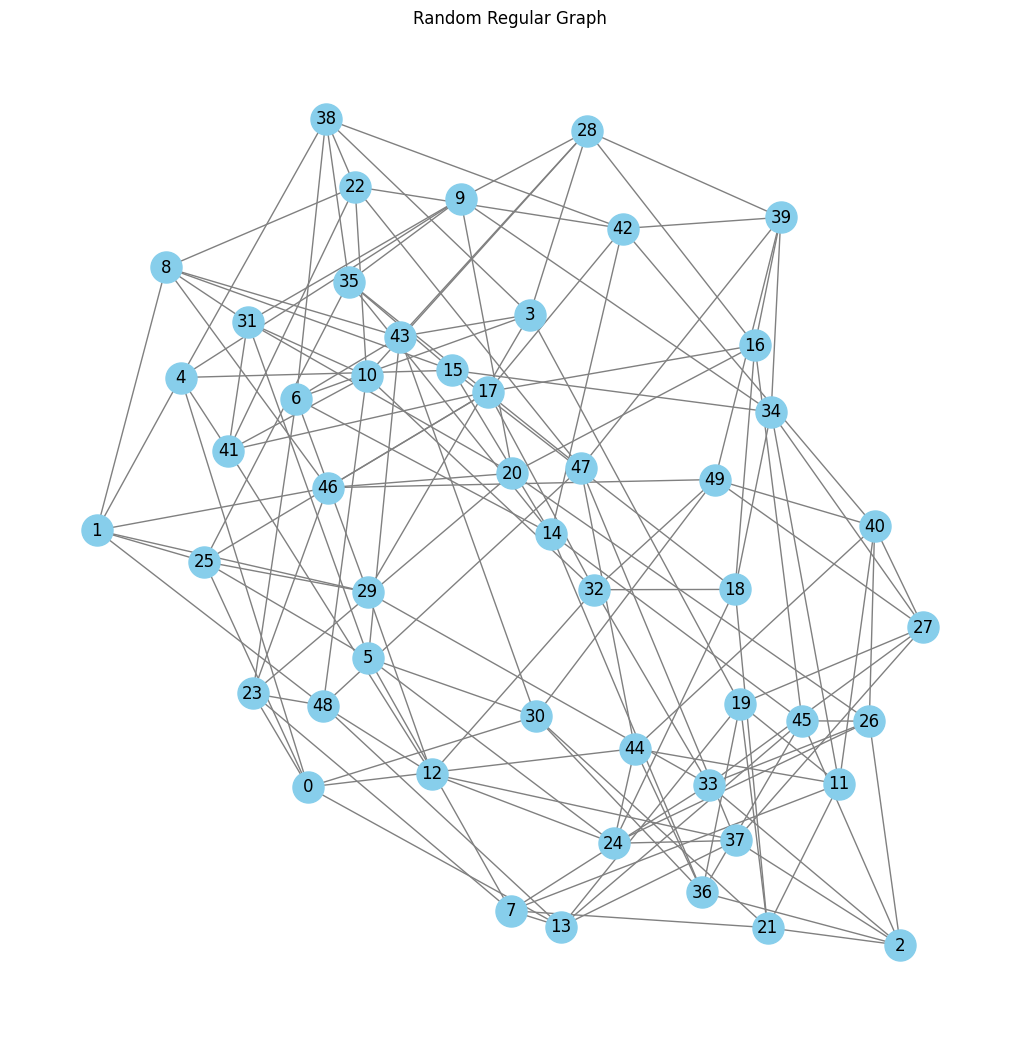

Initial solution: [31, 27, 49, 20, 1, 42, 34, 4, 6, 3, 23], Metric dimension: 11
Shaking operation: add on solution: [31, 27, 49, 20, 1, 42, 34, 4, 6, 3, 23]
Trying operation: add on [31, 27, 49, 20, 1, 42, 34, 4, 6, 3, 23, 30]
Trying operation: remove on [31, 27, 49, 20, 1, 42, 34, 4, 6, 3, 23, 30]
Trying operation: swap on [27, 49, 20, 1, 42, 34, 4, 6, 3, 23, 30]
Trying operation: add on [27, 49, 20, 1, 42, 34, 4, 6, 3, 23, 30]
Trying operation: remove on [27, 49, 20, 1, 42, 34, 4, 6, 3, 23, 30]
Trying operation: swap on [49, 20, 1, 42, 34, 4, 6, 3, 23, 30]
Trying operation: add on [49, 20, 1, 42, 34, 4, 6, 3, 23, 30]
Trying operation: remove on [49, 20, 1, 42, 34, 4, 6, 3, 23, 30]
Trying operation: swap on [20, 1, 42, 34, 4, 6, 3, 23, 30]
Trying operation: add on [20, 1, 42, 34, 4, 6, 3, 23, 30]
Trying operation: remove on [20, 1, 42, 34, 4, 6, 3, 23, 30]
Trying operation: swap on [1, 42, 34, 4, 6, 3, 23, 30]
Trying operation: add on [1, 42, 34, 4, 6, 3, 23, 30]
Trying operation: re

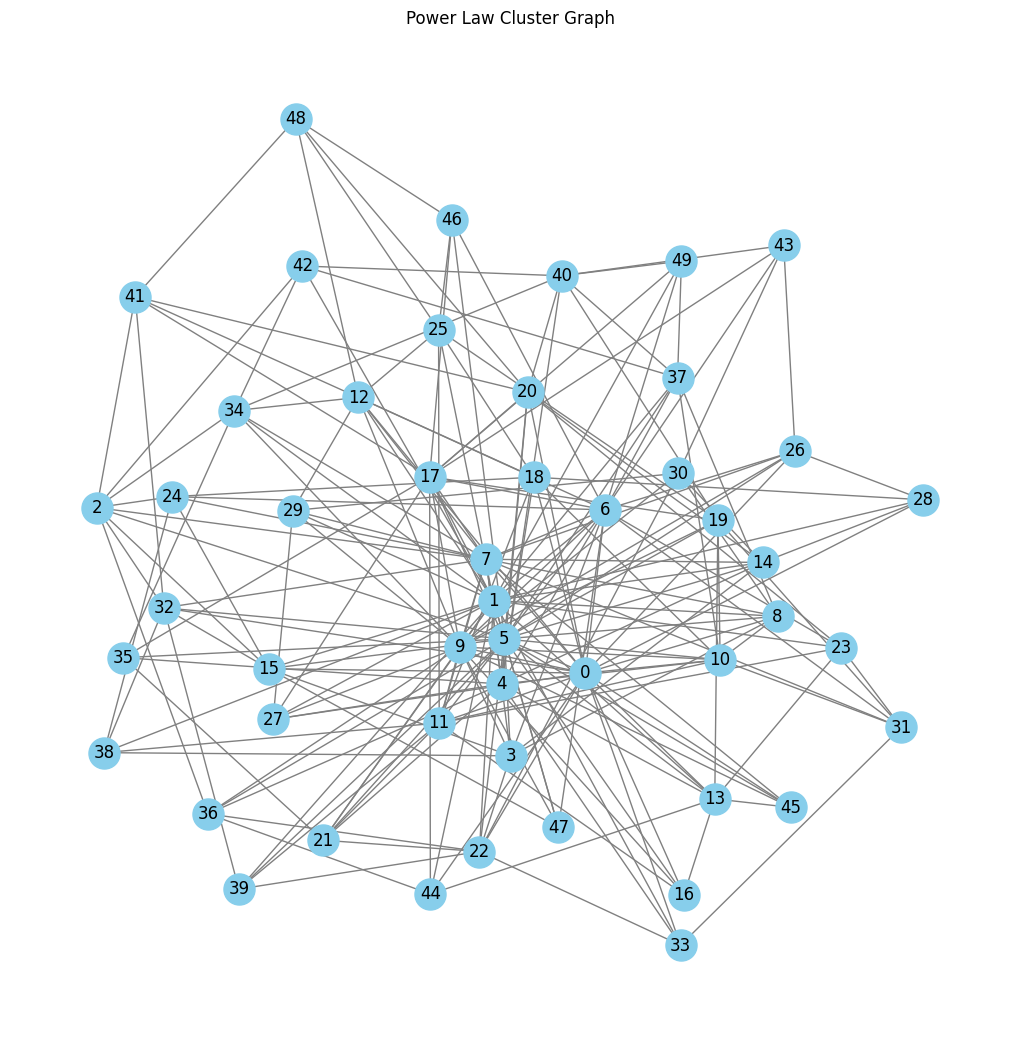

Initial solution: [35, 49, 11, 16, 19, 15, 17, 3, 27, 46, 23, 24, 32, 36, 43, 12, 28, 5, 1, 38, 13, 7, 22, 48, 2, 31, 41, 10, 21, 26, 25, 29, 20, 18, 45, 39, 4, 0, 40, 34, 8, 30, 14], Metric dimension: 43
Shaking operation: remove on solution: [35, 49, 11, 16, 19, 15, 17, 3, 27, 46, 23, 24, 32, 36, 43, 12, 28, 5, 1, 38, 13, 7, 22, 48, 2, 31, 41, 10, 21, 26, 25, 29, 20, 18, 45, 39, 4, 0, 40, 34, 8, 30, 14]
Trying operation: add on [35, 49, 11, 16, 19, 15, 17, 3, 27, 46, 23, 32, 36, 43, 12, 28, 5, 1, 38, 13, 7, 22, 48, 2, 31, 41, 10, 21, 26, 25, 29, 20, 18, 45, 39, 4, 0, 40, 34, 8, 30, 14]
Trying operation: remove on [35, 49, 11, 16, 19, 15, 17, 3, 27, 46, 23, 32, 36, 43, 12, 28, 5, 1, 38, 13, 7, 22, 48, 2, 31, 41, 10, 21, 26, 25, 29, 20, 18, 45, 39, 4, 0, 40, 34, 8, 30, 14]
Trying operation: swap on [49, 11, 16, 19, 15, 17, 3, 27, 46, 23, 32, 36, 43, 12, 28, 5, 1, 38, 13, 7, 22, 48, 2, 31, 41, 10, 21, 26, 25, 29, 20, 18, 45, 39, 4, 0, 40, 34, 8, 30, 14]
Trying operation: add on [49, 11,

In [22]:

max_iterations_list = [10, 50, 100]
time_limits = [0.3, 0.2, 0.1]

# Erdős-Rényi Random Graph
print("\nErdős-Rényi Random Graph")
n = 50
p = 0.05
G_erdos_renyi = generate_connected_erdos_renyi(n, p)
draw_graph(G_erdos_renyi, "Erdős-Rényi Random Graph")
if not nx.is_connected(G_erdos_renyi):
    print("Erdős-Rényi random graph is not connected, skipping parameter optimization.")
else:
    best_parameters = optimize_parameters(G_erdos_renyi, max_iterations_list, time_limits)
    print("Best parameters for Erdős-Rényi random graph:", best_parameters)

# Barabási-Albert Scale-Free Graph
print("\nBarabási-Albert Scale-Free Graph")
n = 50
m = 5
G_barabasi_albert = generate_connected_barabasi_albert(n, m)
draw_graph(G_barabasi_albert, "Barabási-Albert Scale-Free Graph")
if not nx.is_connected(G_barabasi_albert):
    print("Barabási-Albert graph is not connected, skipping parameter optimization.")
else:
    best_parameters = optimize_parameters(G_barabasi_albert, max_iterations_list, time_limits)
    print("Best parameters for Barabási-Albert scale-free graph:", best_parameters)

# Watts-Strogatz Small-World Graph
print("\nWatts-Strogatz Small-World Graph")
n = 50
k = 10
p = 0.1
G_watts_strogatz = generate_connected_watts_strogatz(n, k, p)
draw_graph(G_watts_strogatz, "Watts-Strogatz Small-World Graph")
if not nx.is_connected(G_watts_strogatz):
    print("Watts-Strogatz graph is not connected, skipping parameter optimization.")
else:
    best_parameters = optimize_parameters(G_watts_strogatz, max_iterations_list, time_limits)
    print("Best parameters for Watts-Strogatz small-world graph:", best_parameters)

# Random Regular Graph
print("\nRandom Regular Graph")
n = 50
d = 6
G_random_regular = generate_connected_random_regular(n, d)
draw_graph(G_random_regular, "Random Regular Graph")
if not nx.is_connected(G_random_regular):
    print("Random regular graph is not connected, skipping parameter optimization.")
else:
    best_parameters = optimize_parameters(G_random_regular, max_iterations_list, time_limits)
    print("Best parameters for Random regular graph:", best_parameters)

# Power Law Cluster Graph
print("\nPower Law Cluster Graph")
n = 50
m = 5
p = 0.1
G_powerlaw_cluster = generate_connected_powerlaw(n, m, p)
draw_graph(G_powerlaw_cluster, "Power Law Cluster Graph")
if not nx.is_connected(G_powerlaw_cluster):
    print("Power Law Cluster graph is not connected, skipping parameter optimization.")
else:
    best_parameters = optimize_parameters(G_powerlaw_cluster, max_iterations_list, time_limits)
    print("Best parameters for Power Law Cluster graph:", best_parameters)



Erdős-Rényi Random Graph


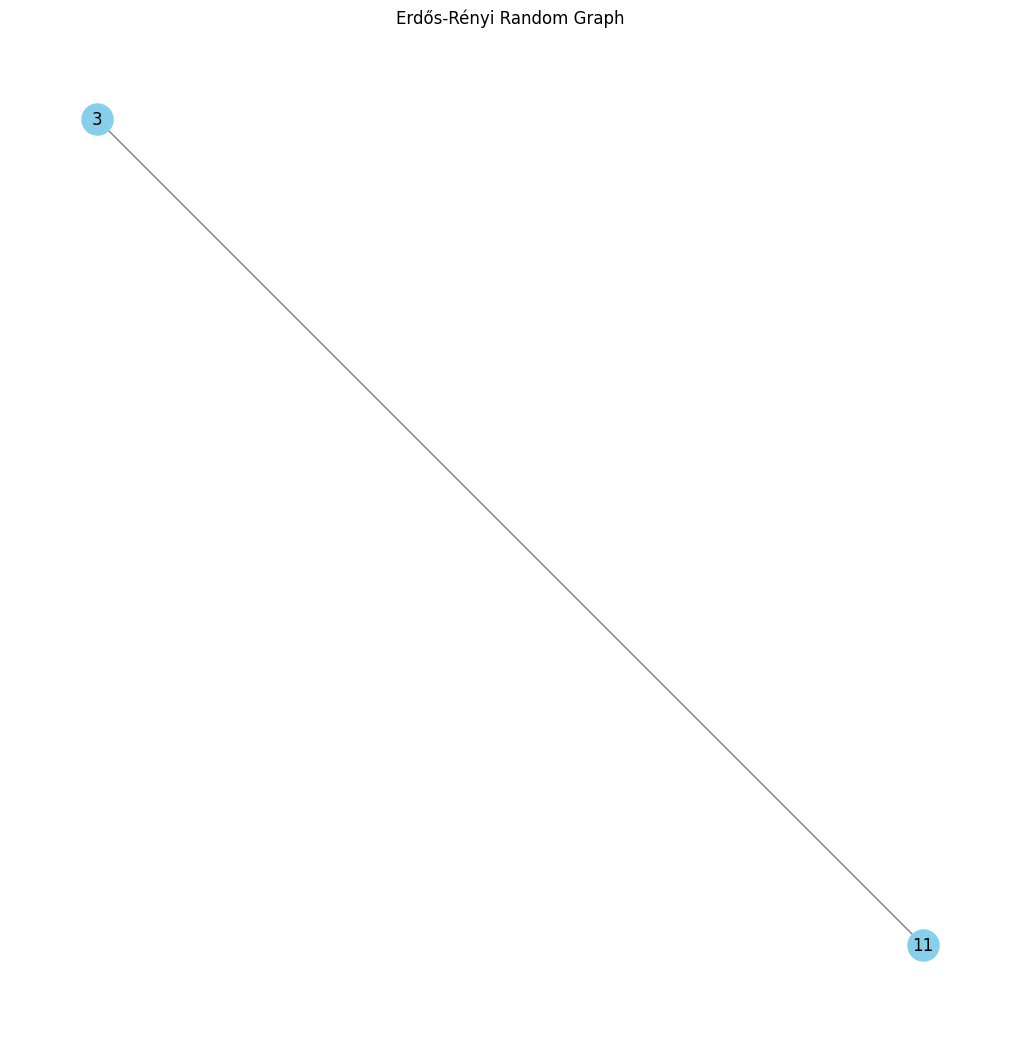

Initial solution: [3], Metric dimension: 1
Shaking operation: add on solution: [3]
Trying operation: add on [3, 11]
Trying operation: remove on [3, 11]
Trying operation: swap on [11]
Trying operation: add on [11]
Trying operation: remove on [11]
Trying operation: swap on [11]
Shaking operation: swap on solution: [11]
Trying operation: add on [3]
Trying operation: remove on [3]
Trying operation: swap on [3]
Shaking operation: swap on solution: [3]
Trying operation: add on [11]
Trying operation: remove on [11]
Trying operation: swap on [11]
Shaking operation: remove on solution: [11]
Trying operation: add on []
Trying operation: remove on [3]
Trying operation: swap on [3]
Trying operation: add on [3]
Trying operation: remove on [3]
Trying operation: swap on [3]
Shaking operation: swap on solution: [3]
Trying operation: add on [11]
Trying operation: remove on [11]
Trying operation: swap on [11]
Shaking operation: swap on solution: [11]
Trying operation: add on [3]
Trying operation: remove

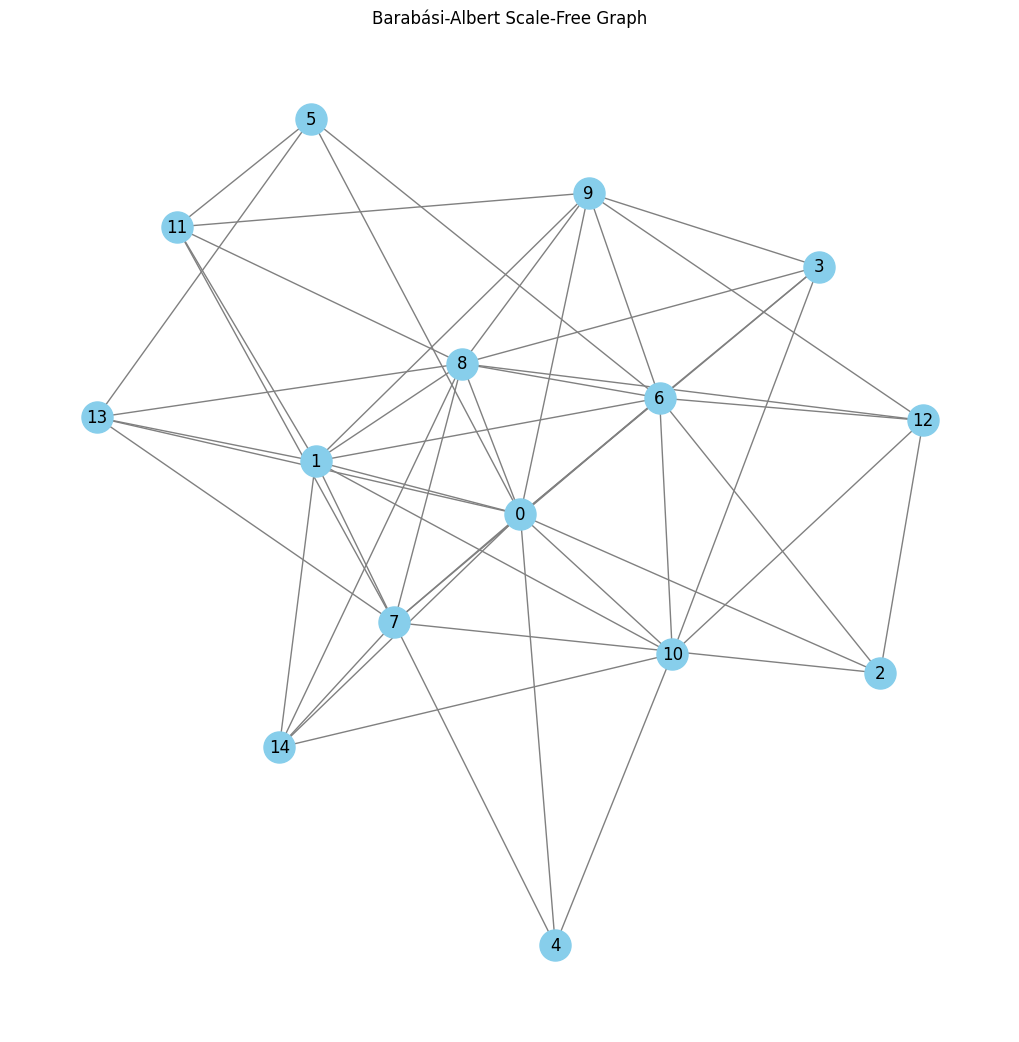

Initial solution: [9, 10, 12, 2, 11, 1, 14, 7, 13, 4, 0, 3, 5, 6, 8], Metric dimension: 15
Shaking operation: swap on solution: [9, 10, 12, 2, 11, 1, 14, 7, 13, 4, 0, 3, 5, 6, 8]
Trying operation: add on [9, 10, 12, 2, 11, 1, 14, 7, 13, 4, 0, 3, 5, 6, 8]
Trying operation: remove on [9, 10, 12, 2, 11, 1, 14, 7, 13, 4, 0, 3, 5, 6, 8]
Trying operation: swap on [10, 12, 2, 11, 1, 14, 7, 13, 4, 0, 3, 5, 6, 8]
Trying operation: add on [10, 12, 2, 11, 1, 14, 7, 13, 4, 0, 3, 5, 6, 8]
Trying operation: remove on [10, 12, 2, 11, 1, 14, 7, 13, 4, 0, 3, 5, 6, 8]
Trying operation: swap on [12, 2, 11, 1, 14, 7, 13, 4, 0, 3, 5, 6, 8]
Trying operation: add on [12, 2, 11, 1, 14, 7, 13, 4, 0, 3, 5, 6, 8]
Trying operation: remove on [12, 2, 11, 1, 14, 7, 13, 4, 0, 3, 5, 6, 8]
Trying operation: swap on [2, 11, 1, 14, 7, 13, 4, 0, 3, 5, 6, 8]
Trying operation: add on [2, 11, 1, 14, 7, 13, 4, 0, 3, 5, 6, 8]
Trying operation: remove on [2, 11, 1, 14, 7, 13, 4, 0, 3, 5, 6, 8]
Trying operation: swap on [11, 1,

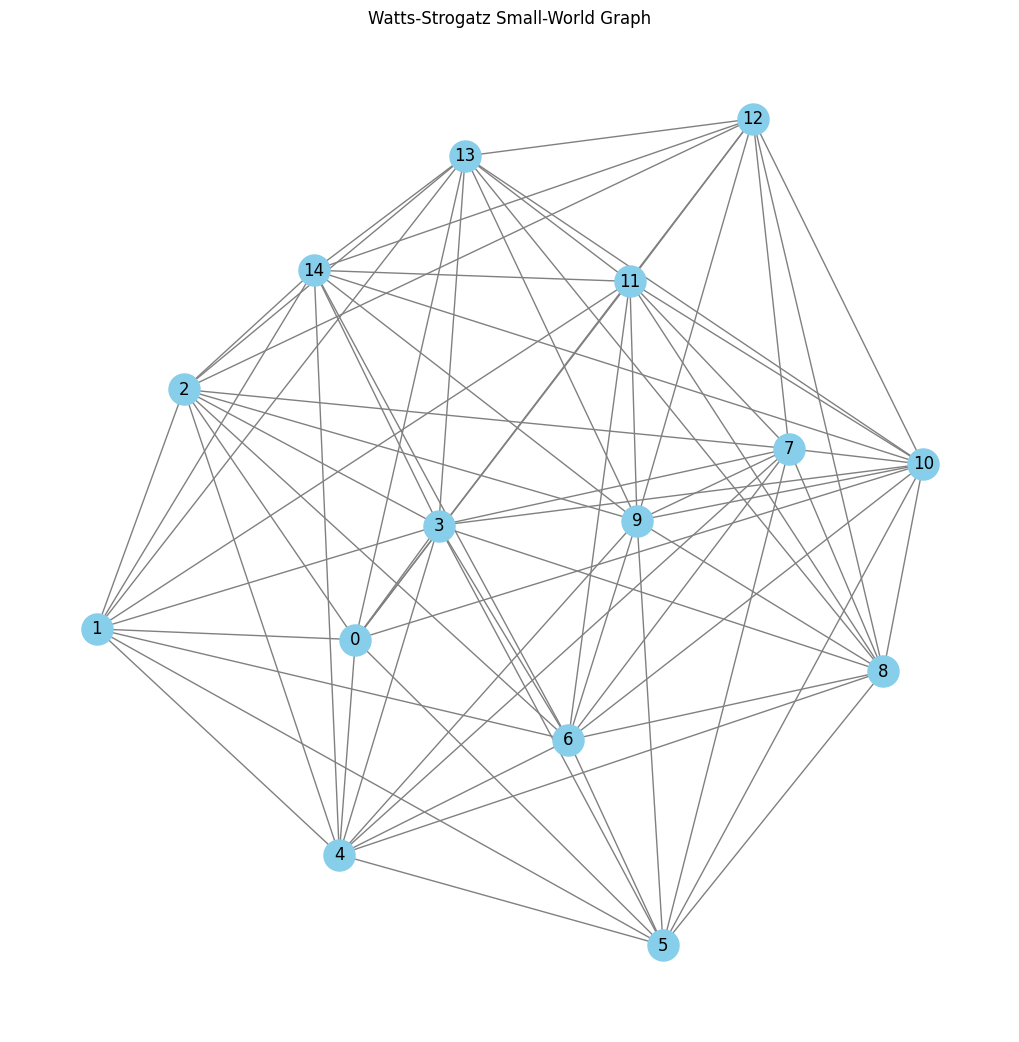

Initial solution: [12, 14, 2, 8], Metric dimension: inf
Shaking operation: add on solution: [12, 14, 2, 8]
Trying operation: add on [12, 14, 2, 8, 4]
Trying operation: remove on [12, 14, 2, 8, 4, 3]
Trying operation: swap on [14, 2, 8, 4, 3]
Trying operation: add on [14, 2, 8, 4, 3]
Trying operation: remove on [14, 2, 8, 4, 3]
Trying operation: swap on [14, 2, 8, 4, 3]
Shaking operation: add on solution: [14, 2, 8, 4, 3]
Trying operation: add on [14, 2, 8, 4, 3, 9]
Trying operation: remove on [14, 2, 8, 4, 3, 9]
Trying operation: swap on [14, 2, 8, 4, 3]
Trying operation: add on [14, 2, 8, 4, 3]
Trying operation: remove on [14, 2, 8, 4, 3]
Trying operation: swap on [14, 2, 8, 4, 3]
Shaking operation: add on solution: [14, 2, 8, 4, 3]
Trying operation: add on [14, 2, 8, 4, 3, 9]
Trying operation: remove on [14, 2, 8, 4, 3, 9]
Trying operation: swap on [14, 2, 8, 4, 3]
Trying operation: add on [14, 2, 8, 4, 3]
Trying operation: remove on [14, 2, 8, 4, 3]
Trying operation: swap on [14, 2,

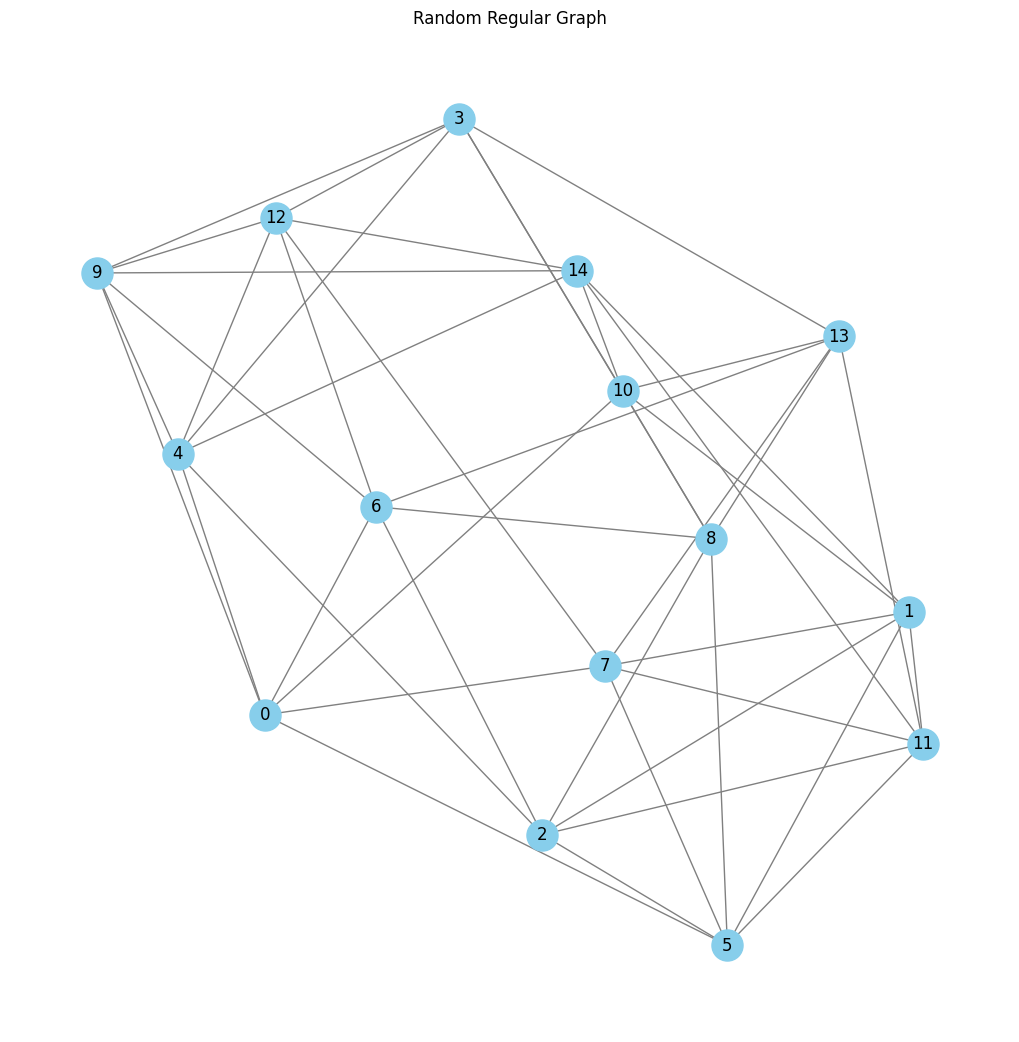

Initial solution: [14, 12, 6, 8, 4, 10, 1, 13, 9, 3, 5, 7, 2, 0], Metric dimension: 14
Shaking operation: add on solution: [14, 12, 6, 8, 4, 10, 1, 13, 9, 3, 5, 7, 2, 0]
Trying operation: add on [14, 12, 6, 8, 4, 10, 1, 13, 9, 3, 5, 7, 2, 0, 11]
Trying operation: remove on [14, 12, 6, 8, 4, 10, 1, 13, 9, 3, 5, 7, 2, 0, 11]
Trying operation: swap on [12, 6, 8, 4, 10, 1, 13, 9, 3, 5, 7, 2, 0, 11]
Trying operation: add on [12, 6, 8, 4, 10, 1, 13, 9, 3, 5, 7, 2, 0, 11]
Trying operation: remove on [12, 6, 8, 4, 10, 1, 13, 9, 3, 5, 7, 2, 0, 11]
Trying operation: swap on [6, 8, 4, 10, 1, 13, 9, 3, 5, 7, 2, 0, 11]
Trying operation: add on [6, 8, 4, 10, 1, 13, 9, 3, 5, 7, 2, 0, 11]
Trying operation: remove on [6, 8, 4, 10, 1, 13, 9, 3, 5, 7, 2, 0, 11]
Trying operation: swap on [8, 4, 10, 1, 13, 9, 3, 5, 7, 2, 0, 11]
Trying operation: add on [8, 4, 10, 1, 13, 9, 3, 5, 7, 2, 0, 11]
Trying operation: remove on [8, 4, 10, 1, 13, 9, 3, 5, 7, 2, 0, 11]
Trying operation: swap on [4, 10, 1, 13, 9, 3, 5

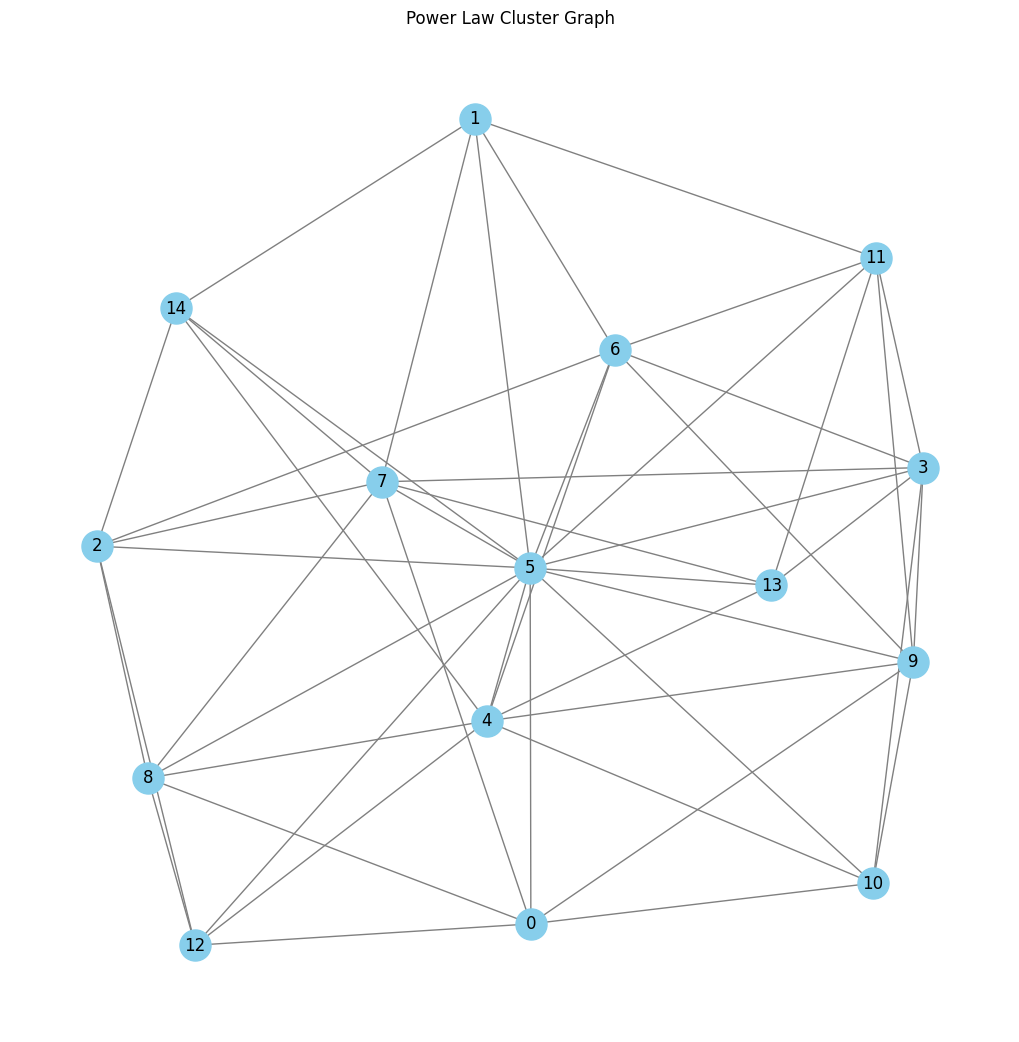

Initial solution: [8, 6, 4, 1, 14, 2], Metric dimension: inf
Shaking operation: add on solution: [8, 6, 4, 1, 14, 2]
Trying operation: add on [8, 6, 4, 1, 14, 2, 3]
Trying operation: remove on [8, 6, 4, 1, 14, 2, 3, 0]
Trying operation: swap on [8, 6, 1, 14, 2, 3, 0]
Trying operation: add on [8, 6, 1, 14, 2, 3, 0]
Trying operation: remove on [8, 6, 1, 14, 2, 3, 0]
Trying operation: swap on [8, 6, 14, 2, 3, 0]
Trying operation: add on [8, 6, 14, 2, 3, 0]
Trying operation: remove on [8, 6, 14, 2, 3, 0]
Trying operation: swap on [8, 6, 2, 3, 0]
Trying operation: add on [8, 6, 2, 3, 0]
Trying operation: remove on [8, 6, 2, 3, 0]
Trying operation: swap on [8, 6, 2, 3, 0]
Shaking operation: swap on solution: [8, 6, 2, 3, 0]
Trying operation: add on [8, 6, 2, 11, 0]
Trying operation: remove on [8, 6, 2, 11, 0, 1]
Trying operation: swap on [8, 6, 2, 0, 1]
Trying operation: add on [8, 6, 2, 0, 1]
Trying operation: remove on [8, 6, 2, 0, 1]
Trying operation: swap on [8, 6, 2, 0, 1]
Shaking opera

In [23]:

max_iterations_list = [10, 50, 100]
time_limits = [0.3, 0.2, 0.1]

# Erdős-Rényi Random Graph
print("\nErdős-Rényi Random Graph")
n = 15
p = 0.05
G_erdos_renyi = generate_connected_erdos_renyi(n, p)
draw_graph(G_erdos_renyi, "Erdős-Rényi Random Graph")
if not nx.is_connected(G_erdos_renyi):
    print("Erdős-Rényi random graph is not connected, skipping parameter optimization.")
else:
    best_parameters = optimize_parameters(G_erdos_renyi, max_iterations_list, time_limits)
    print("Best parameters for Erdős-Rényi random graph:", best_parameters)

# Barabási-Albert Scale-Free Graph
print("\nBarabási-Albert Scale-Free Graph")
n = 15
m = 5
G_barabasi_albert = generate_connected_barabasi_albert(n, m)
draw_graph(G_barabasi_albert, "Barabási-Albert Scale-Free Graph")
if not nx.is_connected(G_barabasi_albert):
    print("Barabási-Albert graph is not connected, skipping parameter optimization.")
else:
    best_parameters = optimize_parameters(G_barabasi_albert, max_iterations_list, time_limits)
    print("Best parameters for Barabási-Albert scale-free graph:", best_parameters)

# Watts-Strogatz Small-World Graph
print("\nWatts-Strogatz Small-World Graph")
n = 15
k = 10
p = 0.1
G_watts_strogatz = generate_connected_watts_strogatz(n, k, p)
draw_graph(G_watts_strogatz, "Watts-Strogatz Small-World Graph")
if not nx.is_connected(G_watts_strogatz):
    print("Watts-Strogatz graph is not connected, skipping parameter optimization.")
else:
    best_parameters = optimize_parameters(G_watts_strogatz, max_iterations_list, time_limits)
    print("Best parameters for Watts-Strogatz small-world graph:", best_parameters)

# Random Regular Graph
print("\nRandom Regular Graph")
n = 15
d = 6
G_random_regular = generate_connected_random_regular(n, d)
draw_graph(G_random_regular, "Random Regular Graph")
if not nx.is_connected(G_random_regular):
    print("Random regular graph is not connected, skipping parameter optimization.")
else:
    best_parameters = optimize_parameters(G_random_regular, max_iterations_list, time_limits)
    print("Best parameters for Random regular graph:", best_parameters)

# Power Law Cluster Graph
print("\nPower Law Cluster Graph")
n = 15
m = 5
p = 0.1
G_powerlaw_cluster = generate_connected_powerlaw(n, m, p)
draw_graph(G_powerlaw_cluster, "Power Law Cluster Graph")
if not nx.is_connected(G_powerlaw_cluster):
    print("Power Law Cluster graph is not connected, skipping parameter optimization.")
else:
    best_parameters = optimize_parameters(G_powerlaw_cluster, max_iterations_list, time_limits)
    print("Best parameters for Power Law Cluster graph:", best_parameters)
